In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
import matplotlib.pyplot as plt
import timeit

In [2]:
# Pre-processing of dataset
df=pd.read_csv('digit-recognizer/train.csv')
df=df.sample(frac=1)
val_data = df[:8400]      # 20% of dataset
train_data = df[8400:]    # 80% of dataset
device='cpu'
onehot_encoder = OneHotEncoder(sparse=False)
train_target_labels = torch.tensor(train_data['label'].values.astype(np.float32))
train_target = torch.Tensor(onehot_encoder.fit_transform(train_target_labels.view(-1,1)))  #One-Hot Encoding
train_target = train_target.to(device).float()
train = torch.tensor(train_data.drop('label', axis = 1).values.astype(np.float32)) 
val_target_labels = torch.tensor(val_data['label'].values.astype(np.float32))
val_target = torch.Tensor(onehot_encoder.fit_transform(val_target_labels.view(-1,1)))  #One-Hot Encoding
val_target = val_target.to(device).float()
val = torch.tensor(val_data.drop('label', axis = 1).values.astype(np.float32)) 
train=train.view(-1,1,28,28)/255
val=val.view(-1,1,28,28)/255
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 4096, shuffle = True)
val_tensor = torch.utils.data.TensorDataset(val, val_target) 
val_loader = torch.utils.data.DataLoader(dataset = val_tensor, batch_size = 4096, shuffle = True)

data_loaders = {"train": train_loader, "val": val_loader}

/home/chirag/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/chirag/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

In [3]:
class linear(nn.Module):
    """ 
        Linear activation function
        
        Range: (-∞,∞)
    """
    def __init__(self,slope=None):
        """
        Parameters:
                    slope - trainable parameter
        """
        super(linear,self).__init__()
        if slope==None:
            self.slope=Parameter(torch.tensor(1.0))
        else:
            self.slope=Parameter(torch.tensor(slope))        
        self.slope.requiresGrad = True 
        
    def forward(self, x):
        """
        Parameters: 
            x: Input tensor

        Returns: 
            y: Output tensor given by f(x)= slope.x
        """
        y = x*self.slope
        return y

Linear activation function with slope 1.00


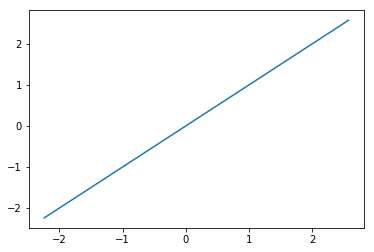

In [4]:
print("Linear activation function with slope 1.00")
x=torch.sort(torch.randn(100)).values
activation=linear()
y=activation(x)
plt.plot(x.numpy(),y.detach().numpy())

In [5]:
class sigmoid(nn.Module):
    """ 
            Sigmoid activation function

            Range: (0,1)
            
            Drawbacks:
            1. Sigmoids saturate and kill gradients
            2. Sigmoid outputs are not zero-centered.
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor given by f(x) = 1/(1+exp(-x))
        """
        y=1/(1+torch.exp((-1)*x))
        return y

Sigmoid activation function


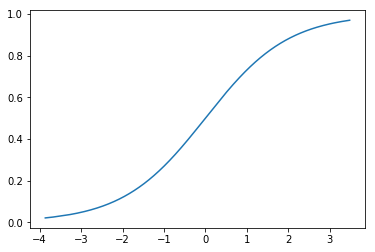

In [6]:
print("Sigmoid activation function")
x=torch.sort(torch.randn(10000)).values
activation=sigmoid()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [7]:
class relu(nn.Module):
    """ 
            ReLU activation function

            Range: (0,∞)
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor given by f(x) = max(0,x)
        """
        y=torch.clamp(x,0)
        return y

ReLU activation function


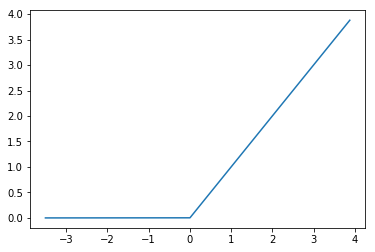

In [8]:
print("ReLU activation function")
x=torch.sort(torch.randn(10000)).values
activation=relu()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [9]:
class leaky_relu(nn.Module):
    """ 
           Leaky ReLU activation function

           Range: (-∞,∞)
            
           Advantage:
                Prevents the problem of dying neurons in ReLU due to fragile gradients
    """
    def __init__(self,alpha=0.01):
        """
        Parameters:
            input_features - input features
            alpha - constant parameter
          
        Returns: 
            y: Output tensor given by f(x)= slope.x
        """
        super().__init__()
        self.alpha=alpha
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor
        """
        y_negative_region=x*self.alpha
        y=torch.where(x>=0,x,y_negative_region)
        return y

Leaky ReLU activation function with alpha(negative-slope) 0.03


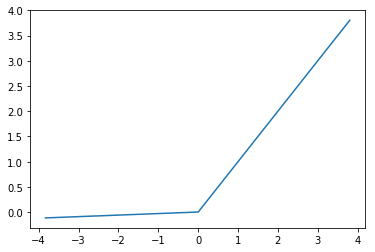

In [10]:
print("Leaky ReLU activation function with alpha(negative-slope) 0.03")
x=torch.sort(torch.randn(10000)).values
activation=leaky_relu(alpha=0.03)
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [11]:
class soft_plus(nn.Module):
    """ 
            SoftPlus activation function
         
            Range: (0,∞)
            
            Interesting note: Derivative is equal to sigmoid function
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor given by ln (1+exp(x))
        """
        y=torch.log(1+torch.exp(x))
        return y

SoftPlus activation function


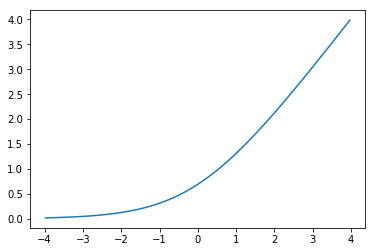

In [12]:
print("SoftPlus activation function")
x=torch.sort(torch.randn(10000)).values
activation=soft_plus()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [13]:
class tanh(nn.Module):
    """ 
            Tanh activation function
         
            Range: (-1,1)
            
            Interesting note: It can be scaled to sigmoid as tanh(x)=2sigmoid(2x)-1
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output
        """
        sigma=sigmoid()
        y=2*sigma(2*x) - 1
        return y

Tanh activation function


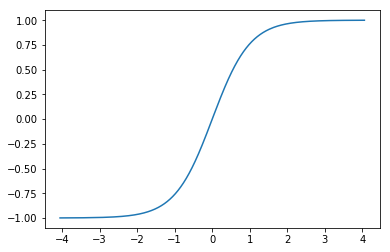

In [14]:
print("Tanh activation function")
x=torch.sort(torch.randn(10000)).values
activation=tanh()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [15]:
class swish(nn.Module):
    """ 
            Swish activation function
         
            Range: (≈-0.278,∞)
                
            Interesting note: It is bounded below and unbounded above, so similar to ReLU
      """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
            Parameters: 
                x: Input tensor

            Returns: 
                y: Output tensor given by f(x)= x * sigmoid(x)
        """
        sigma=sigmoid()
        y=x*sigma(x)
        return y

Swish activation function


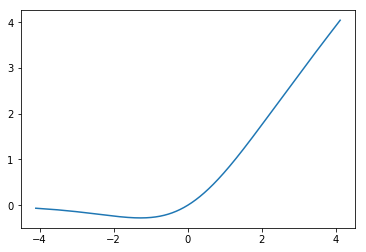

In [16]:
print("Swish activation function")
x=torch.sort(torch.randn(10000)).values
activation=swish()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [17]:
class mish(nn.Module):
    """ 
            Mish activation function
         
            Range: (≈-0.31,∞)
                
            Interesting note: It is bounded below and unbounded above, so similar to ReLU
      """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
            Parameters: 
                x: Input tensor

            Returns: 
                y: Output tensor given by f(x)= x * tanh(soft-plus(x))
        """
        Tanh=tanh()
        SoftPlus=soft_plus()
        y=x*Tanh(SoftPlus(x))
        return y

Mish activation function


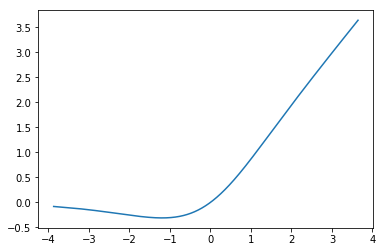

In [18]:
print("Mish activation function")
x=torch.sort(torch.randn(10000)).values
activation=mish()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [19]:
def train_model(model,data_loaders ):
    '''
    Function trains the model and prints out the training log.
    INPUT:
        model - initialized PyTorch model ready for training
        train_loader - PyTorch dataloader for training data
        val_loader - PyTorch dataloader for evaluation on cross-validation data
    '''
    
    loss_fn = nn.BCELoss()
    learning_rate = 3e-3
    num_epochs = 5
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for e in range(num_epochs):
        print('Epoch {}/{}'.format(e, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            
            running_loss = 0
            for images, labels in data_loaders[phase]:
                labels = labels.to(device='cpu', dtype=torch.float)
                log_probs = model(images)
                loss = loss_fn(log_probs, labels)                
                if phase=='train':    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
            if phase=='train':
                print("Training loss: "+str(running_loss))
            else:
                print("Validation loss: "+str(running_loss))

In [20]:
class CNNClassifier(nn.Module):
    '''
    A classifier based on CNN architecture
    '''
    def __init__(self,activation):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=0),
            activation,
            nn.MaxPool2d(2))
 
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0),
            activation,
            nn.MaxPool2d(2))
    
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, padding=0),
            activation,
            nn.MaxPool2d(2))
        
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, padding=0),
            activation)
                
        self.fc1 = nn.Sequential(
            nn.Linear(1*1*128, 128),
            activation)
        
        self.fc2 = nn.Sequential(
            nn.Linear(128, 64),
            activation)
        
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        
        out = self.block1(x)
        
        out = self.block2(out)
        
        out = self.block3(out)
        
        out = self.block4(out)
        
        # Flatten the output of block4
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        
        out = self.fc2(out)

        out = self.fc3(out)
    
        out = F.softmax(out,dim=1)    
        
        return out

In [21]:
activation_functions = {"linear": linear, "sigmoid": sigmoid,"relu": relu,"leaky_relu": leaky_relu,
                       "soft_plus": soft_plus, "tanh": tanh, "swish": swish,"mish" : mish}

for activation in activation_functions:
    
    print("\n \n Activation Function : "+activation)
    start = timeit.default_timer()

    activation_function = activation_functions[activation]()
    model = CNNClassifier(activation_function)
    train_model(model,data_loaders)

    stop = timeit.default_timer()
    print('Time Elapsed : ' + str(stop - start) + ' seconds ') 

    # Prediciting output on Validation Set
    y=[]
    for images, labels in val_loader:
        log_probs = model(images)
        target=np.argmax(log_probs.detach().numpy(),axis=1)
        y=np.hstack((y,target))
    y=y.astype(np.int32)
    print('accuracy : ',np.mean(y==val_target_labels.numpy())*100,'%')


 
 Activation Function : linear
Epoch 0/4
----------
Training loss: 2.5386477261781693
Validation loss: 0.5125829428434372
Epoch 1/4
----------
Training loss: 1.2965108379721642
Validation loss: 0.27110200375318527
Epoch 2/4
----------
Training loss: 0.7095886766910553
Validation loss: 0.18393702059984207
Epoch 3/4
----------
Training loss: 0.46583862230181694
Validation loss: 0.12346021085977554
Epoch 4/4
----------
Training loss: 0.3279237598180771
Validation loss: 0.10107746720314026
Time Elapsed : 51.931049032000374 seconds 
accuracy :  9.964285714285715 %

 
 Activation Function : sigmoid
Epoch 0/4
----------
Training loss: 2.933335930109024
Validation loss: 0.9761532247066498
Epoch 1/4
----------
Training loss: 2.926721751689911
Validation loss: 0.9750734567642212
Epoch 2/4
----------
Training loss: 2.9262951612472534
Validation loss: 0.9760203659534454
Epoch 3/4
----------
Training loss: 2.9252399802207947
Validation loss: 0.9742337167263031
Epoch 4/4
----------
Training loss: 

In [24]:
# Prediciting output on Kaggle Test Set
test=pd.read_csv('digit-recognizer/test.csv')
test_data = torch.tensor(test.values.astype(np.float32)) 
test_target = torch.zeros(test_data.shape[0],1)
test_data=test_data.view(-1,1,28,28)/255

test_tensor = torch.utils.data.TensorDataset(test_data, test_target) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = 4096, shuffle = False)
y=[]
for images, labels in test_loader:
    log_probs = model(images)
    target=np.argmax(log_probs.detach().numpy(),axis=1)
    y=np.hstack((y,target))

ind = np.array(range(1,y.shape[0]+1))
y = y.astype(np.int32)
res = pd.DataFrame({'ImageId': ind[:], 'Label': y[:]})
res.to_csv('submission.csv',index=False)